# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans 
from sklearn.decomposition import PCA
from scipy.stats import itemfreq, chisquare

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in tpd.read_csv('./data/cars.csv')he general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

### Data examination for the files:

In [3]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [5]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
azdias['CAMEO_DEUG_2015'].head(10)

0    NaN
1      8
2      4
3      2
4      6
5      8
6      4
7      2
8      1
9      1
Name: CAMEO_DEUG_2015, dtype: object

In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CAMEO_DEUG_2015,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [9]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [10]:
feat_info.tail()

,attribute,information_level,type,missing_or_unknown
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


In [11]:
feat_info['missing_or_unknown'].describe()

count       85
unique       9
top       [-1]
freq        26
Name: missing_or_unknown, dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [13]:
feat_type = feat_info['type']
feat_type_unique = feat_type.unique()
print(feat_type_unique)

['categorical' 'ordinal' 'numeric' 'mixed' 'interval']


In [14]:
for _type in feat_type_unique:
    print('The number of features with type: {} = {}'.format(_type, feat_info.loc[feat_type == _type].shape[0]))

The number of features with type: categorical = 21
The number of features with type: ordinal = 49
The number of features with type: numeric = 7
The number of features with type: mixed = 7
The number of features with type: interval = 1


In [15]:
# Conversion of sting values to integers:

def convert_to_list(string):
    result=[]
    value = string[1:-1].split(',')
    for i in value:
        if i and not i.isalpha():
            result.append(int(i))
        
        else:
            result.append(i.strip())
    return result
    

In [16]:
feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(convert_to_list)

In [17]:
feat_info['missing_or_unknown'].describe()

count       85
unique       9
top       [-1]
freq        26
Name: missing_or_unknown, dtype: object

In [18]:
missing_data= dict(zip(feat_info["attribute"], feat_info['missing_or_unknown']))
print(missing_data)

{'AGER_TYP': [-1, 0], 'ALTERSKATEGORIE_GROB': [-1, 0, 9], 'ANREDE_KZ': [-1, 0], 'CJT_GESAMTTYP': [0], 'FINANZ_MINIMALIST': [-1], 'FINANZ_SPARER': [-1], 'FINANZ_VORSORGER': [-1], 'FINANZ_ANLEGER': [-1], 'FINANZ_UNAUFFAELLIGER': [-1], 'FINANZ_HAUSBAUER': [-1], 'FINANZTYP': [-1], 'GEBURTSJAHR': [0], 'GFK_URLAUBERTYP': [''], 'GREEN_AVANTGARDE': [''], 'HEALTH_TYP': [-1, 0], 'LP_LEBENSPHASE_FEIN': [0], 'LP_LEBENSPHASE_GROB': [0], 'LP_FAMILIE_FEIN': [0], 'LP_FAMILIE_GROB': [0], 'LP_STATUS_FEIN': [0], 'LP_STATUS_GROB': [0], 'NATIONALITAET_KZ': [-1, 0], 'PRAEGENDE_JUGENDJAHRE': [-1, 0], 'RETOURTYP_BK_S': [0], 'SEMIO_SOZ': [-1, 9], 'SEMIO_FAM': [-1, 9], 'SEMIO_REL': [-1, 9], 'SEMIO_MAT': [-1, 9], 'SEMIO_VERT': [-1, 9], 'SEMIO_LUST': [-1, 9], 'SEMIO_ERL': [-1, 9], 'SEMIO_KULT': [-1, 9], 'SEMIO_RAT': [-1, 9], 'SEMIO_KRIT': [-1, 9], 'SEMIO_DOM': [-1, 9], 'SEMIO_KAEM': [-1, 9], 'SEMIO_PFLICHT': [-1, 9], 'SEMIO_TRADV': [-1, 9], 'SHOPPER_TYP': [-1], 'SOHO_KZ': [-1], 'TITEL_KZ': [-1, 0], 'VERS_TYP': [-

In [19]:
for col in missing_data.keys():
    nans_old= azdias[col].isnull().sum()
    azdias.loc[azdias[col].isin(missing_data[col]), col] = np.nan
    nans_new = azdias[col].isnull().sum()
    if nans_new != nans_old:
        print(col)
        print('The number of features with NaN values was: ', nans_old)
        print('The number of features with NaN values has become: ', nans_new)
        print('-'*10)

AGER_TYP
The number of features with NaN values was:  0
The number of features with NaN values has become:  685843
----------
ALTERSKATEGORIE_GROB
The number of features with NaN values was:  0
The number of features with NaN values has become:  2881
----------
GEBURTSJAHR
The number of features with NaN values was:  0
The number of features with NaN values has become:  392318
----------
HEALTH_TYP
The number of features with NaN values was:  0
The number of features with NaN values has become:  111196
----------
LP_LEBENSPHASE_FEIN
The number of features with NaN values was:  4854
The number of features with NaN values has become:  97632
----------
LP_LEBENSPHASE_GROB
The number of features with NaN values was:  4854
The number of features with NaN values has become:  94572
----------
LP_FAMILIE_FEIN
The number of features with NaN values was:  4854
The number of features with NaN values has become:  77792
----------
LP_FAMILIE_GROB
The number of features with NaN values was:  4854
Th

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [20]:
feat_nan_mean = azdias.isnull().mean().sort_values(ascending=False)
print(feat_nan_mean)

TITEL_KZ        0.997576
AGER_TYP        0.769554
KK_KUNDENTYP    0.655967
KBA05_BAUMAX    0.534687
GEBURTSJAHR     0.440203
                  ...   
SEMIO_RAT       0.000000
SEMIO_KRIT      0.000000
SEMIO_DOM       0.000000
SEMIO_TRADV     0.000000
ZABEOTYP        0.000000
Length: 85, dtype: float64


In [21]:
feat_nan_mean[:10]

TITEL_KZ          0.997576
AGER_TYP          0.769554
KK_KUNDENTYP      0.655967
KBA05_BAUMAX      0.534687
GEBURTSJAHR       0.440203
ALTER_HH          0.348137
KKK               0.177357
REGIOTYP          0.177357
W_KEIT_KIND_HH    0.166051
KBA05_ANTG1       0.149597
dtype: float64

In [22]:
# Assessment of features in terms of missing or unknown data "converted to NaN" :

miss_values_df = feat_nan_mean.to_frame()
miss_values_df.reset_index(level=0, inplace=True)
miss_values_df.columns = ['features','missing_values_mean']
miss_values_df['information_level'] = feat_info['information_level']
miss_values_df['type'] = feat_info['type']
print(miss_values_df.head(10))

         features  missing_values_mean information_level         type
0        TITEL_KZ             0.997576            person  categorical
1        AGER_TYP             0.769554            person      ordinal
2    KK_KUNDENTYP             0.655967            person  categorical
3    KBA05_BAUMAX             0.534687            person  categorical
4     GEBURTSJAHR             0.440203            person      ordinal
5        ALTER_HH             0.348137            person      ordinal
6             KKK             0.177357            person      ordinal
7        REGIOTYP             0.177357            person      ordinal
8  W_KEIT_KIND_HH             0.166051            person      ordinal
9     KBA05_ANTG1             0.149597            person      ordinal


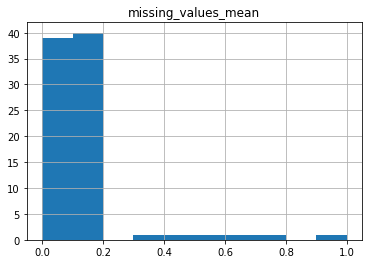

In [23]:
miss_values_df.hist();

In [24]:
no_miss_value_count = miss_values_df[miss_values_df['missing_values_mean'] == 0].shape[0]
miss_value_count_5 = miss_values_df[miss_values_df['missing_values_mean'] > 0.05].shape[0]
miss_value_count_10 = miss_values_df[miss_values_df['missing_values_mean'] > 0.10].shape[0]
miss_value_count_15 = miss_values_df[miss_values_df['missing_values_mean'] > 0.15].shape[0]
miss_value_count_20 = miss_values_df[miss_values_df['missing_values_mean'] > 0.2].shape[0]
miss_value_count_25 = miss_values_df[miss_values_df['missing_values_mean'] > 0.25].shape[0]

print(no_miss_value_count)
print(miss_value_count_5)
print(miss_value_count_10)
print(miss_value_count_15)
print(miss_value_count_20)
print(miss_value_count_25)

print(miss_value_count_15/85)

24
53
46
9
6
6
0.10588235294117647


In [25]:
# Features classification based on the percentage of missing values:

selected_conditions = [
    (miss_values_df['missing_values_mean'] == 0),
    (miss_values_df['missing_values_mean'] > 0) & (miss_values_df['missing_values_mean'] <= 0.1),
    (miss_values_df['missing_values_mean'] > 0.1) & (miss_values_df['missing_values_mean'] <= 0.15),
    (miss_values_df['missing_values_mean'] > 0.15)
    ]
definition = ['no_missing_values', 'low%_missing_values', 'medium%_missing_values', 'high%_missing_values']
miss_values_df['nan_degree'] = np.select(selected_conditions, definition)

print(miss_values_df.tail(10))

       features  missing_values_mean information_level     type  \
75    SEMIO_MAT                  0.0    macrocell_plz8  ordinal   
76   SEMIO_VERT                  0.0    macrocell_plz8  ordinal   
77   SEMIO_LUST                  0.0    macrocell_plz8  ordinal   
78    SEMIO_ERL                  0.0    macrocell_plz8  ordinal   
79   SEMIO_KULT                  0.0    macrocell_plz8    mixed   
80    SEMIO_RAT                  0.0    macrocell_plz8  ordinal   
81   SEMIO_KRIT                  0.0    macrocell_plz8  ordinal   
82    SEMIO_DOM                  0.0         community  ordinal   
83  SEMIO_TRADV                  0.0         community  ordinal   
84     ZABEOTYP                  0.0         community  ordinal   

           nan_degree  
75  no_missing_values  
76  no_missing_values  
77  no_missing_values  
78  no_missing_values  
79  no_missing_values  
80  no_missing_values  
81  no_missing_values  
82  no_missing_values  
83  no_missing_values  
84  no_missing_values 

In [26]:
sum(miss_values_df['missing_values_mean'])/85

0.11054139407027633

In [27]:
# Removing outliers from the data frame based on the percentage of missing values:

outliers = miss_values_df[miss_values_df['missing_values_mean']>0.15].features
print(outliers)
azdias.drop(outliers, axis=1, inplace=True)
azdias.shape

0          TITEL_KZ
1          AGER_TYP
2      KK_KUNDENTYP
3      KBA05_BAUMAX
4       GEBURTSJAHR
5          ALTER_HH
6               KKK
7          REGIOTYP
8    W_KEIT_KIND_HH
Name: features, dtype: object


(891221, 76)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

- The number of features with no missing values = 24 
- All the features have a variable missing data rate with around 11% in average including those with no missing data.  
- Almost 89.5% of the features have missing data rate <= 0.15     
- The number of features considered to have a high missing values = 9 
- The features which are collected from persons have the highest missing data.
- The features that have been removed due to high missing data rate ">15%" are: [W_KEIT_KIND_HH, KKK, REGIOTYP, ALTER_HH,  GEBURTSJAHR, KBA05_BAUMAX, KK_KUNDENTYP, AGER_TYP, and TITEL_KZ]



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [28]:
# Identification of the amount of missing data in each row:
azdias['row_missing_data'] = azdias.isnull().mean(axis=1)
print(azdias['row_missing_data'].describe())

count    891221.000000
mean          0.067489
std           0.162723
min           0.000000
25%           0.000000
50%           0.000000
75%           0.013158
max           0.605263
Name: row_missing_data, dtype: float64


In [29]:
azdias['row_missing_data']

0         0.526316
1         0.000000
2         0.000000
3         0.052632
4         0.000000
            ...   
891216    0.039474
891217    0.052632
891218    0.052632
891219    0.000000
891220    0.000000
Name: row_missing_data, Length: 891221, dtype: float64

In [30]:
# Dividing the data into two subsets based on the number of missing values in each row:
threshhold_value = 0.2
low_missing_data_rows = azdias.loc[azdias['row_missing_data'] < threshhold_value]
high_missing_data_rows = azdias.loc[azdias['row_missing_data'] > threshhold_value]
print('The number of rows with missing values lower than 0.2 = {}, percentage of {}%'.format(low_missing_data_rows.shape[0], (low_missing_data_rows.shape[0]/azdias.shape[0])*100))
print('The number of rows with missing values greater than 0.2 = {}, percentage of {}%'.format(high_missing_data_rows.shape[0], (high_missing_data_rows.shape[0]/azdias.shape[0])*100))


The number of rows with missing values lower than 0.2 = 794935, percentage of 89.19617019796436%
The number of rows with missing values greater than 0.2 = 96286, percentage of 10.803829802035635%


In [31]:
# Compare the distribution of values for at least five columns where there are no or few missing values, between the two subsets.
# comparing the two subsets

# Columns with no missing values and rows of no missing values :
low_missing_data_columns = low_missing_data_rows.dropna(axis=1)

# Columns with no missing values and rows of high missing values:
high_missing_data_columns = high_missing_data_rows.dropna(axis=1)

# Columns with no missing values:
no_missing_data_columns = list(set(low_missing_data_columns.columns).intersection(high_missing_data_columns.columns))

print('The number of columns with no missing data = {}'.format(len(no_missing_data_columns)))
no_missing_data_columns[:6]


The number of columns with no missing data = 25


['SEMIO_SOZ',
 'SEMIO_RAT',
 'FINANZTYP',
 'SEMIO_KULT',
 'FINANZ_SPARER',
 'FINANZ_HAUSBAUER']

C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


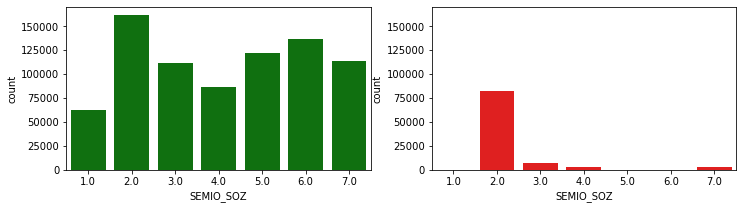

C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


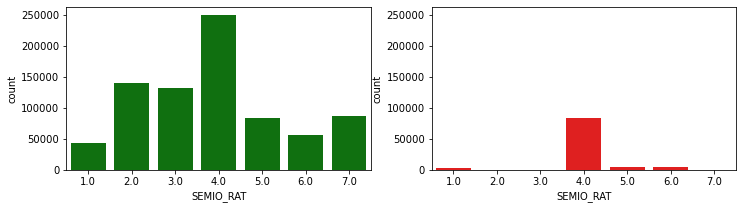

C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


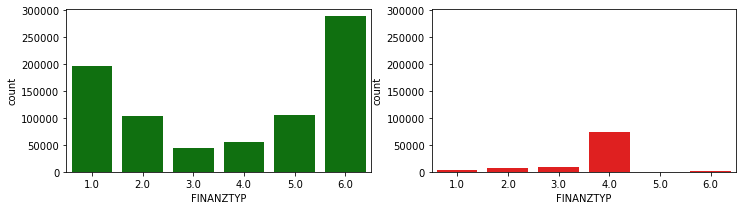

C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


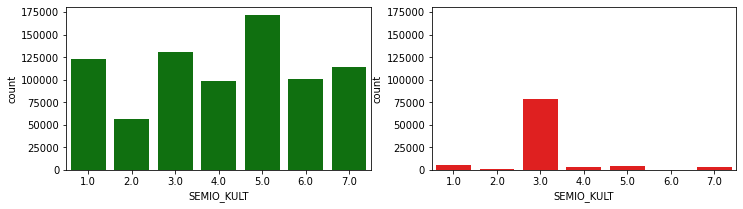

C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


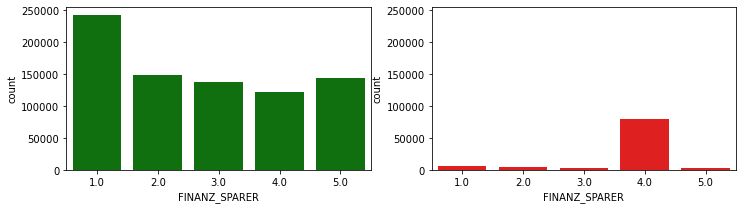

In [32]:
# Defining a function to plot *****************
def compare(column, df1, df2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 3))
    ax1 = plt.subplot(1,2,1)
    ax1 = sns.countplot(df1[column], color='g')
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    ax2 = sns.countplot(df2[column], color='r')
    plt.show()

# Comaring the distribution of values for 5 columns:
for col in no_missing_data_columns[:5]:
    compare(col, low_missing_data_columns, high_missing_data_columns)

In [33]:
# Removing rows with high missing data:
df = low_missing_data_rows
# Drop the 'row_nan_pct' column
df = df.drop('row_missing_data', axis=1)
print(df.head())
print(df.shape)

   ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
1                   1.0        2.0            5.0                1.0   
2                   3.0        2.0            3.0                1.0   
3                   4.0        2.0            2.0                4.0   
4                   3.0        1.0            5.0                4.0   
5                   1.0        2.0            2.0                3.0   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
1            5.0               2.0             5.0                    4.0   
2            4.0               1.0             2.0                    3.0   
3            2.0               5.0             2.0                    1.0   
4            3.0               4.0             1.0                    3.0   
5            1.0               5.0             2.0                    2.0   

   FINANZ_HAUSBAUER  FINANZTYP  ...  PLZ8_ANTG1  PLZ8_ANTG2  PLZ8_ANTG3  \
1               5.0        1.

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

- The max missing data rate for all the rows = 0.605263
- 75% of the rows have missing data rate = 0.013158 
- Threshhold of 0.2 have been used to classify the data into 2 separate groups to compare the data distribution. 
- Percentage of rows have missing values > 0.2 = 10.8%
- Percentage of rows have missing values < 0.2 = 89.2%
- The distributions of the first five columns are discontinuous and appear to be quite different.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [34]:
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'],
      dtype=object)

In [35]:
# filtering feat_info based on the selected columns:
feat_info = feat_info[feat_info.columns[:-1]]
feat_info = feat_info[feat_info.attribute.isin(df.columns)]
feat_info.shape

(76, 3)

In [36]:
# Exploring the remaining features with respect to its info type:
for feat_type in feat_info['type'].unique():
    print('The number of features with type: {} = {}'.format(feat_type, feat_info.loc[feat_info['type'] == feat_type].shape[0]))

The number of features with type: ordinal = 46
The number of features with type: categorical = 18
The number of features with type: mixed = 6
The number of features with type: numeric = 6


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assessement of categorical variables:
df_categorical_columns = feat_info[feat_info.type == 'categorical'].attribute
df_categorical_columns

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [38]:
print(df[df_categorical_columns].nunique().sort_values())

ANREDE_KZ            2
OST_WEST_KZ          2
VERS_TYP             2
SOHO_KZ              2
GREEN_AVANTGARDE     2
NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_STATUS_GROB       5
LP_FAMILIE_GROB      5
FINANZTYP            6
ZABEOTYP             6
CJT_GESAMTTYP        6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64


In [39]:
df[df_categorical_columns].dtypes

ANREDE_KZ           float64
CJT_GESAMTTYP       float64
FINANZTYP           float64
GFK_URLAUBERTYP     float64
GREEN_AVANTGARDE    float64
LP_FAMILIE_FEIN     float64
LP_FAMILIE_GROB     float64
LP_STATUS_FEIN      float64
LP_STATUS_GROB      float64
NATIONALITAET_KZ    float64
SHOPPER_TYP         float64
SOHO_KZ             float64
VERS_TYP            float64
ZABEOTYP            float64
GEBAEUDETYP         float64
OST_WEST_KZ          object
CAMEO_DEUG_2015      object
CAMEO_DEU_2015       object
dtype: object

In [40]:
df[df_categorical_columns[-3:]].head(10)

,OST_WEST_KZ,CAMEO_DEUG_2015,CAMEO_DEU_2015
1,W,8,8A
2,W,4,4C
3,W,2,2A
4,W,6,6B
5,W,8,8C
6,W,4,4A
7,W,2,2D
8,W,1,1A
9,W,1,1E
10,W,9,9D


In [41]:
df['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [42]:
# Encoding the data for OST_WEST_KZ feature:
df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0, 'W': 1})

In [43]:
# Selecting the multilevel categorical features:
categorical_nunique = df[df_categorical_columns].nunique()
categorical_to_encode = categorical_nunique[categorical_nunique>2]
categorical_to_encode.sort_values()

NATIONALITAET_KZ     3
SHOPPER_TYP          4
LP_FAMILIE_GROB      5
LP_STATUS_GROB       5
CJT_GESAMTTYP        6
FINANZTYP            6
ZABEOTYP             6
GEBAEUDETYP          7
CAMEO_DEUG_2015      9
LP_STATUS_FEIN      10
LP_FAMILIE_FEIN     11
GFK_URLAUBERTYP     12
CAMEO_DEU_2015      44
dtype: int64

In [44]:
df.shape

(794935, 76)

In [45]:
# Dropping the multilevel categorical features:
df = df.drop(columns=categorical_to_encode.index, axis=0)
df.shape

(794935, 63)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- Data contains 18 categorical features.
- OST WEST KZ: has two values O, W that have been re-encoded to 0, 1, respectively.
- CAMEO DEUG 2015: contains 9 numeric values encoded as object dtype.
- The remaining binary features have been kept as they are.  
- 13 multilevel features are dropped to keep things straightforward for the following steps.  

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
mixed_columns = feat_info.loc[feat_info['type'] == 'mixed'].attribute
mixed_columns

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [47]:
df[mixed_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 794935 entries, 1 to 891220
Data columns (total 6 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   LP_LEBENSPHASE_FEIN    745836 non-null  float64
 1   LP_LEBENSPHASE_GROB    748639 non-null  float64
 2   PRAEGENDE_JUGENDJAHRE  766724 non-null  float64
 3   WOHNLAGE               794935 non-null  float64
 4   CAMEO_INTL_2015        790604 non-null  object 
 5   PLZ8_BAUMAX            774498 non-null  float64
dtypes: float64(5), object(1)
memory usage: 58.6+ MB


In [48]:
df['PRAEGENDE_JUGENDJAHRE'].unique()

array([14., 15.,  8.,  3., 10., 11.,  5.,  9.,  6.,  4., nan,  2.,  1.,
       12., 13.,  7.])

In [49]:
# Investigating "PRAEGENDE_JUGENDJAHRE" and engineering two new variables:
decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
               8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
               14: 6, 15: 6
              }
movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                }

df['engineered_decade'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
df['engineered_movement'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)


In [50]:
print(df['engineered_decade'].value_counts())

6.0    224507
4.0    174642
5.0    151209
3.0    114165
2.0     74133
1.0     28068
Name: engineered_decade, dtype: int64


In [51]:
print(df['engineered_decade'].value_counts())

6.0    224507
4.0    174642
5.0    151209
3.0    114165
2.0     74133
1.0     28068
Name: engineered_decade, dtype: int64


In [52]:
def get_digit(num,digit):
    if not pd.isnull(num):
        num = int(str(num)[digit])
    return num

In [53]:
df['CAMEO_INTL_2015'].unique()

array(['51', '24', '12', '43', '54', '22', '14', '13', '15', '33', '41',
       '34', '55', '25', nan, '23', '31', '52', '35', '45', '44', '32'],
      dtype=object)

In [54]:
# Investigating "CAMEO_INTL_2015" and engineering two new variables:
df['engineered_wealth'] = df['CAMEO_INTL_2015'].apply(get_digit, digit=0)
df['engineered_life_stage'] = df['CAMEO_INTL_2015'].apply(get_digit, digit=1)

In [55]:
print(df['engineered_wealth'].value_counts())

5.0    223422
2.0    190182
4.0    189752
1.0    119246
3.0     68002
Name: engineered_wealth, dtype: int64


In [56]:
print(df['engineered_life_stage'].value_counts())

1.0    244792
4.0    232408
3.0    119363
5.0    116882
2.0     77159
Name: engineered_life_stage, dtype: int64


In [57]:
# Dropping mixed dtype features:
df = df.drop(mixed_columns , axis=1)

In [58]:
df.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,engineered_decade,engineered_movement,engineered_wealth,engineered_life_stage
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,2.0,2.0,4.0
3,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0.0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

- There are six mixed-type features in the dataset.

- From the mixed feature "PRAEGENDE JUGENDJAHRE", two new variables called (engineered_decade, engineered_movement) have been engineered, which combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). The variables engineered_decade and engineered_movement record the two dimensions of the original feature: a binary variable for movement and an interval-type variable for decade.

- From the mixed feature "CAMEO INTL 2015", combines data from two axes: wealth and life stage, two new variables called (engineered_wealth and engineered_life_stage) have been designed. engineered_wealth and engineered_life_stage break apart the original two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables to capture meaning from the original feature.

- To keep things simple, the other four mixed features will be removed.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [59]:
df.shape

(794935, 61)

In [60]:
df.dtypes.unique()

array([dtype('float64'), dtype('int64')], dtype=object)

In [61]:
df.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT',
       'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL',
       'HH_EINKOMMEN_SCORE', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ',
       'BALLRAUM', 'EWDICHTE', 'INNENSTADT', 'GEBAEUDETYP_RASTER',
       'MOBI_REGIO', 'ONLINE_AFFINITAET', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
       'ARBEIT', 'ORTSGR_KLS9', 'RELAT_AB', 'engineered_d

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [62]:
def clean_data(df):
    # Performs feature reduction, re-encoding, and engineering for demographics data:
    df = convert_missingdata_encodings_to_nans(df)
    print('Convert missing value codes into NaN, OK')
    
    # Removing selected columns:
    df = drop_selected_columns(df)
    
    # Removing selected rows:
    df, df_cust_highna = drop_selected_rows(df)
    print('The selected columns and rows were removed')
    
    # Selection, re-encoding, and engineering column values:
    df = reencode_categorical_feat(df)
    df = engineer_mixed_feat(df)
    print('Selection, re-encoding, and engineering column values were done')
    
    # Return the cleaned DF & the high NaN DF:
    return df, df_cust_highna


def convert_missingdata_encodings_to_nans(df, debug=False):
    # Converts to NaN values based on the missing_data_encode dictionary

    for col in missing_data.keys():
        if debug:
            print(col, 'NaN values before: ', df[col].isnull().sum())
        df.loc[df[col].isin(missing_data[col]), col] = np.nan
        if debug:
            print(col, 'NaN values  after: ', df[col].isnull().sum(), '\n')
    return df


def drop_selected_columns(df):
    ''''''
    return df.drop(columns=outliers, axis=1)


def drop_selected_rows(df):
    # Divides the dataset into two categories: One with a percntage of NaN values per row exceeds the threshhold and
    # the other below this threshold:
    
    threshhold = 0.2
    df['row_nan_perc'] = df.isnull().mean(axis=1)
    
    df_lowna = df.loc[df['row_nan_perc'] < threshhold, :].\
                                drop(columns='row_nan_perc', axis=1)
    df_highna = df.loc[df['row_nan_perc'] > threshhold, :].\
                                drop(columns='row_nan_perc', axis=1)

    return df_lowna, df_highna


def reencode_categorical_feat(df):
    # Re-encodes the feature "OST_WEST_KZ" to numeric values:
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 0,
                                                   'W': 1})

    # Selects the features with more than 2 levels:
    df_cat_cols = feat_info[feat_info.type == 'categorical'].attribute
    cat_nunique = df[df_cat_cols].nunique()
    cat_to_encode = cat_nunique[cat_nunique > 2]

    # Drops the multi-level categorical features for the dataset:
    df = df.drop(columns=cat_to_encode.index, axis=0)

    return df


def engineer_mixed_feat(df):
    # Engineers new variables from the mixed features:
    
    # (1) Engineering two new variables from the feature'PRAEGENDE_JUGENDJAHRE':
    decade_dict = {1: 1, 2: 1, 3: 2, 4: 2, 5: 3, 6: 3, 7:  3,
                   8: 4, 9: 4, 10: 5, 11: 5, 12: 5, 13: 5,
                   14: 6, 15: 6
                   }
    movement_dict = {1: 1, 3: 1, 5: 1, 8: 1, 10: 1, 12: 1, 14: 1,
                     2: 2, 4: 2, 6: 2, 7: 2, 9: 2, 11: 2, 13: 2, 15: 2
                     }

    df['ENG_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].map(decade_dict)
    df['ENG_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].map(movement_dict)
    df.drop

    # (2) Engineering two new variables from the feature'CAMEO_INTL_2015':
    df['ENG_WEALTH'] = df['CAMEO_INTL_2015'].apply(
        get_digit, digit=0)
    df['ENG_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(
        get_digit, digit=1)

    # Dropping mixed dtype features:
    mixed_feat_cols = feat_info[feat_info.type == 'mixed'].attribute
    df = df.drop(mixed_feat_cols, axis=1)

    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [63]:
# checking missing rate in the data set:
df.isnull().mean().describe()

count    61.000000
mean      0.010906
std       0.016791
min       0.000000
25%       0.000000
50%       0.000072
75%       0.025709
max       0.046697
dtype: float64

In [64]:
# Investigating the percentage of NaN values for colums:
(df.isnull().mean(axis=0) * 100).sort_values(ascending=False)[:10]

KBA05_ANTG1            4.669690
KBA05_ANTG2            4.669690
KBA05_ANTG3            4.669690
KBA05_ANTG4            4.669690
MOBI_REGIO             4.669690
KBA05_GBZ              4.669690
VERS_TYP               4.544648
HEALTH_TYP             4.544648
engineered_movement    3.548844
engineered_decade      3.548844
dtype: float64

In [65]:
# Investigating the percentage of NaN values for rows:
nan_percentage_rows = (df.isnull().mean(axis=1) * 100).sort_values(ascending=False)
num_rows_nan = nan_percentage_rows[nan_percentage_rows > 0].shape[0]
print('The number of rows with nan values = {}'.format(num_rows_nan))
print('The total percentage of rows that have nan values are : ', round(num_rows_nan/ df.shape[0]  * 100, 4),'%')

The number of rows with nan values = 106228
The total percentage of rows that have nan values are :  13.3631 %


In [66]:
# Fitting the Scaler without NaN values:
no_nan_df = df.dropna(axis=0)
scaler = StandardScaler()
scaler.fit(no_nan_df)

StandardScaler()

In [67]:
# Imputting the missing values in the full df with the mean:
impute = SimpleImputer(missing_values=np.nan, strategy='mean')
x_impute = impute.fit_transform(df)

In [68]:
# Transforming the df after fitting the scaler:
x_scale = scaler.transform(x_impute)

In [69]:
df_scale = pd.DataFrame(x_scale, columns=df.columns)
df_scale.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,engineered_decade,engineered_movement,engineered_wealth,engineered_life_stage
count,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,...,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000,794935.000000
mean,0.005405,0.019864,-0.004811,0.022885,-0.008450,0.024898,0.060517,-0.022344,-0.020599,-0.024382,...,-0.007311,0.000019,0.008345,-0.015396,-0.011206,-0.009901,0.010443,-0.001341,-0.010855,-0.003283
std,0.987334,0.999348,1.009379,1.009645,0.992970,1.012337,1.016974,1.022150,0.986366,0.975951,...,0.985321,0.992212,0.986581,1.000695,0.999405,0.999881,0.981877,0.981243,0.995816,0.992447
min,-1.738330,-1.023197,-1.512418,-1.143095,-1.763660,-1.240354,-1.142171,-1.562624,-0.543995,-1.611668,...,-0.967240,-2.696782,-2.132552,-2.193125,-1.879699,-1.537156,-2.274348,-0.543995,-1.553707,-1.258316
25%,-0.767270,-1.023197,-0.779732,-1.143095,-1.042476,-1.240354,-1.142171,-0.835955,-0.543995,-0.288809,...,-0.967240,-0.632533,-0.334215,-0.184009,-0.574620,-0.800185,-0.902407,-0.543995,-0.871931,-1.258316
50%,0.203789,0.977328,-0.047046,0.216430,0.399894,0.134456,-0.414937,-0.109286,-0.543995,-0.288809,...,0.405547,0.000019,-0.334215,-0.184009,-0.139593,-0.063215,0.010443,-0.543995,0.491620,0.081964
75%,1.174849,0.977328,0.685640,0.896193,1.121078,0.821861,1.039530,0.617383,-0.543995,1.034049,...,0.405547,0.399592,0.564953,0.820550,0.730460,0.673756,1.155505,-0.001341,1.173395,0.752104
max,1.174849,0.977328,1.418327,1.575956,1.121078,1.509267,1.766764,1.344051,1.838251,1.034049,...,1.778335,1.431716,1.464122,1.825108,1.600513,1.410726,1.155505,1.838251,1.173395,1.422245


### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

- Percentage of rows that contain NaNs is 13.3631 %.
- Dropping this data would result in a large volume of data being discarded in order to deal with a considerably smaller amount of truly missing data.
- The StandardScaler function is used to fit the data without the NaNs, then reintroduce them by imputing them with the mean and converting them with the fitted StandardScaler object, resulting in more informative distributions.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [70]:
x_scale.shape

(794935, 61)

In [71]:
# Applyying PCA:

pca = PCA()
df_pca = pca.fit_transform(x_scale)

In [72]:
# Checking the number of components:
components_tot = len(pca.explained_variance_ratio_)

# Generating a sequence for plotting:
components = np.arange(components_tot)

Text(0.5, 1.0, 'Cumulative Explained Variance vs No. of Principal Components')

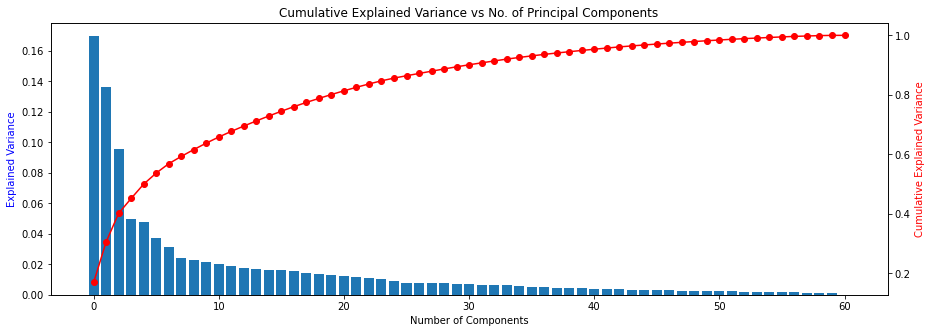

In [73]:
# Investigating the variance for each principal component:
# refer to this blog:https://github.com/S-Tabor/udacity-customer-segmentation-project/blob/master/identify_customer_segments_final.ipynb

fig, ax1 = plt.subplots(figsize=(15,5))
ax1.bar(components, pca.explained_variance_ratio_)
ax1.set_ylabel('Explained Variance', color="blue")
ax1.set_xlabel('Number of Components')

ax2 = ax1.twinx() 
ax2.plot(np.cumsum(pca.explained_variance_ratio_), color="red",marker='o')
ax2.set_ylabel('Cumulative Explained Variance', color="red")
plt.title("Cumulative Explained Variance vs No. of Principal Components")



In [74]:
np.cumsum(pca.explained_variance_ratio_[:30])[-1]

0.8943018533912549

In [75]:
# Re-applyying PCA to the data:
pca = PCA(n_components=30)
pca_30 = pca.fit_transform(x_scale)
pca_30_df = pd.DataFrame(pca_30)


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

- On the scaled dataset, the PCA method is used to plot explained variance against the number of components, as well as cumulative explained variance.
- 30 components are preserved to keep 89.4% of cumulative variation.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [76]:
len(pca.components_[0])

61

In [77]:
df_scale.shape

(794935, 61)

In [78]:
feature_weights = pd.DataFrame(np.round(pca.components_, 4), columns=df_scale.columns)
feature_weights.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,engineered_decade,engineered_movement,engineered_wealth,engineered_life_stage
0,-0.1183,0.0090,-0.2239,0.1483,-0.1131,0.0685,0.0746,0.1698,-0.1035,0.0311,...,0.2176,0.0430,-0.1651,0.1442,0.2002,0.1371,0.0994,-0.1008,0.2062,-0.1236
1,0.2560,0.0970,0.0653,-0.2367,0.2301,-0.2051,-0.2320,0.1211,-0.0122,-0.0547,...,0.0854,0.0131,-0.0685,0.0665,0.0905,0.0650,-0.2443,-0.0103,0.0728,0.0031
2,0.0843,-0.3677,0.1605,-0.1130,0.1058,-0.1974,-0.1086,-0.0420,0.0484,-0.0221,...,0.0479,0.0044,-0.0407,0.0381,0.0520,0.0357,-0.1102,0.0462,0.0301,-0.0090
3,0.0619,-0.0342,-0.0443,-0.0136,0.0044,0.0782,-0.0674,0.0519,-0.3443,-0.0296,...,-0.0099,-0.1307,-0.0884,-0.0319,-0.2035,-0.0865,-0.0336,-0.3412,0.1051,-0.0610
4,0.0023,0.0175,0.0924,-0.0227,-0.0256,-0.0880,0.0671,-0.1795,0.2307,-0.0157,...,0.1053,0.0367,-0.0641,0.0922,0.1933,0.0846,0.0307,0.2289,-0.0800,0.0148


In [79]:
def get_cpn_feat_weight(pca, df, cpn_num):
    # Returns features weights for an number of the PCA objects:
    
    feature_weights = pd.DataFrame(np.round(pca.components_, 4), columns = df.columns)
    weight_nth = feature_weights.iloc[cpn_num - 1, :].sort_values()
    weight_nth = weight_nth.to_frame()
    weight_nth.reset_index(level=0, inplace=True)
    weight_nth.columns = ['column name','weight']
    return weight_nth

In [80]:
def get_topnth_feat(cpn_feat_wgt, n=5):
     # Returns features weights for 5 PCA objects:

    tail_nth = cpn_feat_wgt.head(n).reset_index(drop=True)
    head_nth = cpn_feat_wgt.tail(n).sort_values(by='weight',ascending=False).reset_index(drop=True)
    top_nth = pd.concat([head_nth, tail_nth], axis=1)
    top_nth.columns = ['top_positive_col','top_positive_col_weight','top_negative_col','top_negative_col_weight']
    return top_nth

In [81]:
# Analyzing the first principal component based the corresponding feature names:

cpn_weight_1st = get_cpn_feat_weight(pca, df_scale, 1)
get_topnth_feat(cpn_weight_1st).style.bar(align='mid')


,top_positive_col,top_positive_col_weight,top_negative_col,top_negative_col_weight
0,PLZ8_ANTG3,0.225000,MOBI_REGIO,-0.236300
1,PLZ8_ANTG4,0.217600,FINANZ_MINIMALIST,-0.223900
2,engineered_wealth,0.206200,PLZ8_ANTG1,-0.223100
3,HH_EINKOMMEN_SCORE,0.204500,KBA05_ANTG1,-0.218100
4,ORTSGR_KLS9,0.200200,KBA05_GBZ,-0.212600


**Top 5 Positive**:

- **PLZ8_ANTG3**: Number of 6-10 family houses in the PLZ8 region (0: no 6-10 family homes, 3: high share of 6-10 family homes)
- **PLZ8_ANTG4**: Number of 10+ family houses in the PLZ8 region (0: no 10+ family home, 2: - high share of 10+ family homes)
- **engineered_wealth**: Household wealth - Engineered (1: Wealthy Households, 5: Poorer Households)
- **HH_EINKOMMEN_SCORE**: Estimated household net income (1: highest income, 6: very low income)
- **ORTSGR_KLS9**:Size of community

**Top 5 Negative**:

- **MOBI_REGIO**: Movement patterns (1: very high movement, 6: none)
- **FINANZ_MINIMALIST**: Financial typology - MINIMALIST: low financial interest (1: very high, 5: very low)
- **PLZ8_ANTG1**: Number of 1-2 family houses in the PLZ8 region (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
- **KBA05_ANTG1**: Number of 1-2 family houses in the microcell (0: no 1-2 family homes, 4: very high share of 1-2 family homes)
- **KBA05_GBZ**: Number of buildings in the microcell(1: 1-2 buildings;5: >=23 buildings)


In [82]:
# Analyzing the second principal component based the corresponding feature names:

cpn_weight_2nd = get_cpn_feat_weight(pca, df_scale, 2)
get_topnth_feat(cpn_weight_2nd).style.bar(align='mid')


,top_positive_col,top_positive_col_weight,top_negative_col,top_negative_col_weight
0,ALTERSKATEGORIE_GROB,0.256000,SEMIO_REL,-0.263700
1,SEMIO_ERL,0.236500,engineered_decade,-0.244300
2,FINANZ_VORSORGER,0.230100,FINANZ_SPARER,-0.236700
3,SEMIO_LUST,0.184300,FINANZ_UNAUFFAELLIGER,-0.232000
4,RETOURTYP_BK_S,0.161100,SEMIO_TRADV,-0.227900


**Top 5 Positive**:

- **ALTERSKATEGORIE_GROB**: Estimated age based on given name analysis (1: < 30 years old, 4: > 60 years old, 9: uniformly distributed)
- **SEMIO_ERL**: Personality typology - event-oriented ( 1: highest affinity, 7: lowest affinity)
- **FINANZ_VORSORGER**: Financial be prepared(1: very high)
- **SEMIO_LUST**: Personality typology - sensual-minded ( 1: highest affinity, 7: lowest affinity)
- **RETOURTYP_BK_S**: Return type


**Top 5 Negative**:

- **SEMIO_REL**: Personality typology - religious ( 1: highest affinity, 7: lowest affinity)
- **engineered_decade**: Person’s decade of youth (1: 40s , 6: 90s)
- **FINANZ_SPARER**: Financial typology - money-saver (1: Very high, 5: Very low)
- **FINANZ_UNAUFFAELLIGER**: Financial typology - inconspicuous (1: Very high, 5: Very low)
- **SEMIO_TRADV**: Personality typology

In [83]:
# Analyzing the third principal component based the corresponding feature names:

cpn_weight_3rd = get_cpn_feat_weight(pca, df_scale, 3)
get_topnth_feat(cpn_weight_3rd).style.bar(align='mid')


,top_positive_col,top_positive_col_weight,top_negative_col,top_negative_col_weight
0,SEMIO_VERT,0.351500,ANREDE_KZ,-0.367700
1,SEMIO_SOZ,0.260000,SEMIO_KAEM,-0.329100
2,SEMIO_FAM,0.245000,SEMIO_DOM,-0.306600
3,SEMIO_KULT,0.229800,SEMIO_KRIT,-0.278000
4,FINANZ_MINIMALIST,0.160500,SEMIO_RAT,-0.221500


**Top 5 Positive**:

- **SEMIO_VERT**: Personality typology - VERT: dreamful (1: highest affinity, 7: lowest affinity)
- **SEMIO_SOZ**: Personality typology - SOZ: socially-minded (1: highest affinity, 7: lowest affinity)
- **SEMIO_FAM**: Personality typology - family-minded ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_KULT**: Personality typology - cultural-minded ( 1: highest affinity, 7: lowest affinity)
- **FINANZ_MINIMALIST**: Financial typology

**Top 5 Negative**:

- **ANREDE_KZ**: Gender ( 1: male, 2: female)
- **SEMIO_KAEM**: Personality typology - KAEM: combative attitude ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_DOM**: Personality typology - DOM: dominant-minded ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_KRIT**: Personality typology - KRIT: critical-minded ( 1: highest affinity, 7: lowest affinity)
- **SEMIO_RAT**: Personality typology

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


- **1ST component** represents the population density and financial condition
    - [PLZ8_ANTG3, PLZ8_ANTG4, engineered_wealth, HH_EINKOMMEN_SCORE, ORTSGR_KLS9] have strong positive weights and are associated with people who reside in more densely populated places and have less financial wealth.
    - [MOBI_REGIO, FINANZ_MINIMALIST,PLZ8_ANTG1, KBA05_ANTG1, KBA05_GBZ] have significant negative weights and are linked to people who reside in less densely populated places and have more money.


- **2nd component**  indicates age and personality
    - [ALTERSKATEGORIE_GROB, SEMIO_ERL, FINANZ_VORSORGER , SEMIO_LUST, RETOURTYP_BK_S] have a substantial positive correlation with older persons who are less sensual and event oriented and have less financial planning and home ownership.
    - [SEMIO_REL, engineered_decade, FINANZ_SPARER, FINANZ_UNAUFFAELLIGER, SEMIO_TRADV] have significant negative weights when compared to the younger generation, who have a weaker religious affinity, save less money, are less outgoing, and are less conventional.


- **3rd component**  indicates genderand personality
    - [SEMIO_VERT, SEMIO_SOZ, SEMIO_FAM, SEMIO_KULT, FINANZ_MINIMALIST] are associated with men who are less dreamy, less socially conscious, less culturally conscious, not financial minimalists, and conservative return shopper types.
    - [ANREDE_KZ, SEMIO_KAEM, SEMIO_DOM, SEMIO_KRIT, SEMIO_RAT] have a high negative correlation with women who are less dominant-minded, less critical-minded, less rational, less confrontational, and less likely to invest.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [84]:
max_num_clusters = 30
scores = {}
for i in range(2, max_num_clusters):
    print(i)
    scores[i] = np.abs(KMeans(n_clusters=i).fit(pca_30).score(pca_30))

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


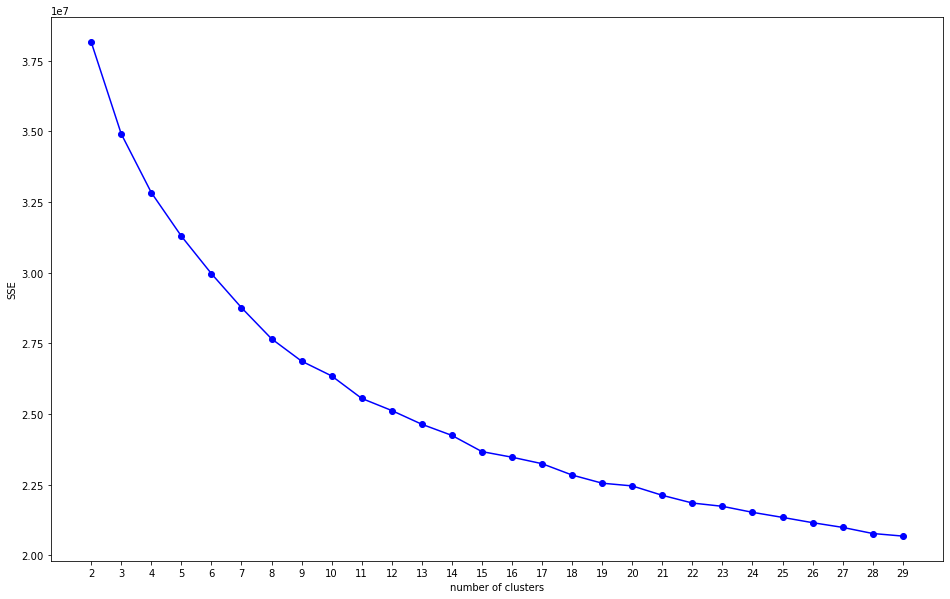

In [85]:
# Plotting the change in cluster distances with the number of clusters:

fig, ax = plt.subplots(figsize=(16,10))    
ax = pd.Series(scores).plot(marker='o', color='b')
ax.set_xticks(np.arange(2, max_num_clusters), minor=False);
ax.set_xlabel("number of clusters")
ax.set_ylabel("SSE");



In [86]:
# Re-fitting the k-means model based on the selected number of clusters and perform predictions 
# for the general population demographics data.
seleted_clusters_num = 15
kmeans_model = KMeans(n_clusters=seleted_clusters_num, n_jobs=-1, random_state=0).fit(pca_30)


C:\Users\AHMED TAMAN\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


In [87]:
print(kmeans_model.labels_)

[ 7 13 12 ...  9  5  2]


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

- A curve was plotted for 30 cluster scores with respect to the Distance to Number of Clusters.

- It is clear from the plot, after the **15** Number of Clusters, that the decrease in the distance to the Number of Clusters  has significantly dropped, so this number of clusters has been used to fit the the KMeans algorithm on the transformed demographics data and predict cluster labels.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [88]:
# Loadding  the customer demographics data:
customer_data = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', delimiter=';')

In [89]:
customer_data.shape

(191652, 85)

In [90]:
customer_data .head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [91]:
# Applyying the clean function on thecustomer demographics data:

df_customer, df_customer_highna = clean_data(customer_data)

Convert missing value codes into NaN, OK
The selected columns and rows were removed
Selection, re-encoding, and engineering column values were done


In [92]:
df_customer.shape

(141232, 61)

In [93]:
df_customer_highna.shape

(50420, 76)

In [94]:
# Perform features transformation:
x_customer_imp = impute.transform(df_customer)

In [95]:
# Perform features scaling:
x_customer_sc = scaler.transform(x_customer_imp)

In [96]:
# Perform dimensionality reduction:
x_customer_pca = pca.transform(x_customer_sc)
x_customer_pca.shape

(141232, 30)

In [97]:
df_customer_pca = pd.DataFrame(x_customer_pca, columns=np.arange(1, 31))
df_customer_pca.describe()

,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
count,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,...,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000,141232.000000
mean,-2.345567,1.289336,1.503895,-0.800492,0.375212,0.059402,0.128845,0.306436,0.182644,0.191559,...,0.026092,-0.011674,0.009754,-0.079017,-0.081523,0.038892,-0.075888,0.025620,-0.077374,0.006550
std,2.675995,2.196004,2.203814,1.876173,1.678848,1.469061,1.395482,1.157662,1.210419,1.240207,...,0.862104,0.852858,0.768223,0.762486,0.691880,0.711051,0.666387,0.665686,0.676423,0.638062
min,-7.920695,-7.804650,-4.995617,-7.349366,-5.297393,-5.439679,-3.230767,-4.046158,-4.857281,-4.845003,...,-9.035270,-11.967658,-7.791086,-3.242796,-2.775275,-2.222921,-9.560165,-3.112213,-3.732047,-13.524825
25%,-4.374164,-0.046584,-0.686216,-2.301024,-0.762031,-0.984153,-0.591999,-0.478869,-0.625673,-0.570933,...,-0.509165,-0.528108,-0.486054,-0.595586,-0.532301,-0.478467,-0.510294,-0.416726,-0.528390,-0.368341
50%,-3.037845,1.213506,2.223196,-0.859006,0.304121,-0.085231,0.057555,0.292102,0.208853,0.147988,...,0.043785,-0.005847,0.017010,-0.071400,-0.107049,-0.006377,-0.090407,0.026860,-0.074282,0.005966
75%,-0.743065,2.702348,3.288724,0.466763,1.248153,1.039030,0.663364,1.114673,1.004163,0.866780,...,0.578069,0.501140,0.507687,0.441713,0.318094,0.585968,0.341331,0.475055,0.377914,0.384461
max,11.461585,11.128686,6.610599,8.888534,11.908971,6.427624,37.354500,8.123037,9.585009,22.126426,...,11.251768,16.464421,10.674646,4.231668,3.341839,2.577160,6.424257,3.383440,3.204571,9.364638


In [98]:
# Perform kmeans Clustering
x_customer_kmeans = kmeans_model.predict(x_customer_pca)

In [99]:
np.unique(x_customer_kmeans)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [100]:
# Compare, for each cluster, the proportion of data  for the customers data and the general population:
def count_dataset(df, dataset_name):
    # Calculate the proportion of data points in each cluster:

    per_dataset = pd.DataFrame(itemfreq(df["labels"]),columns=['label','freq'])
    per_dataset['dataset'] = dataset_name
    per_dataset['freq'] = per_dataset['freq']/per_dataset['freq'].sum()
    return per_dataset



In [101]:
pca_30_df["labels"] = kmeans_model.labels_
df_customer_pca["labels"] = x_customer_kmeans

In [103]:
pop_per_dataset = count_dataset(pca_30_df, 'population')
customer_per_dataset = count_dataset(df_customer_pca, 'customer')
total_per_dataset = pop_per_dataset.append(customer_per_dataset)
print(total_per_dataset)

    label      freq     dataset
0       0  0.069842  population
1       1  0.003979  population
2       2  0.055815  population
3       3  0.067651  population
4       4  0.070153  population
5       5  0.067773  population
6       6  0.092053  population
7       7  0.086115  population
8       8  0.072559  population
9       9  0.095072  population
10     10  0.041842  population
11     11  0.045024  population
12     12  0.090314  population
13     13  0.066321  population
14     14  0.075487  population
0       0  0.015011    customer
1       1  0.019330    customer
2       2  0.089208    customer
3       3  0.308117    customer
4       4  0.021716    customer
5       5  0.006663    customer
6       6  0.169140    customer
7       7  0.007343    customer
8       8  0.077511    customer
9       9  0.013290    customer
10     10  0.034008    customer
11     11  0.022113    customer
12     12  0.074480    customer
13     13  0.111958    customer
14     14  0.030114    customer


<ipython-input-100-77733b4bd1b1>:5: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  per_dataset = pd.DataFrame(itemfreq(df["labels"]),columns=['label','freq'])


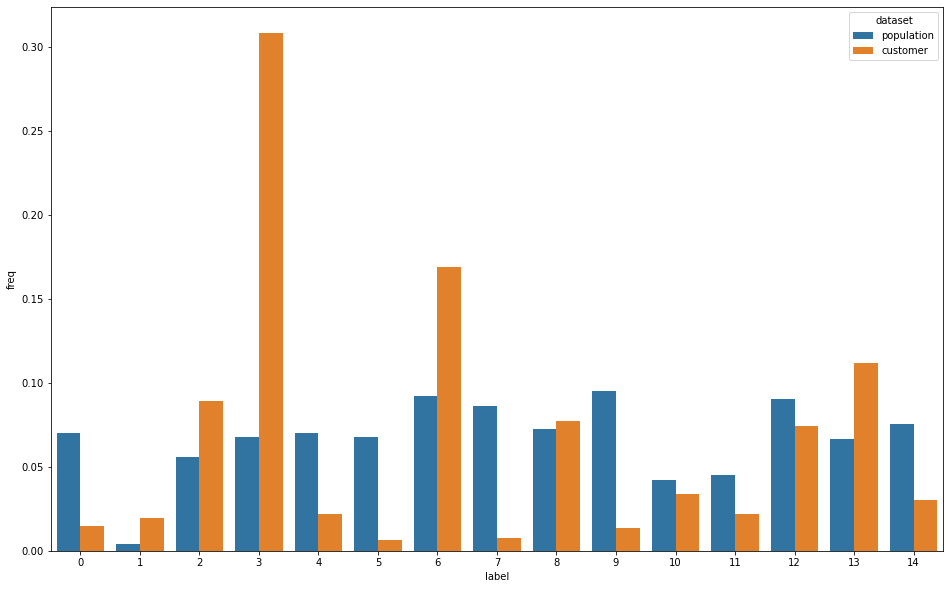

In [104]:
# making a visual plot:
fig, ax = plt.subplots(figsize=(16,10))    
ax=sns.barplot(x='label', y='freq', hue='dataset', data=total_per_dataset)

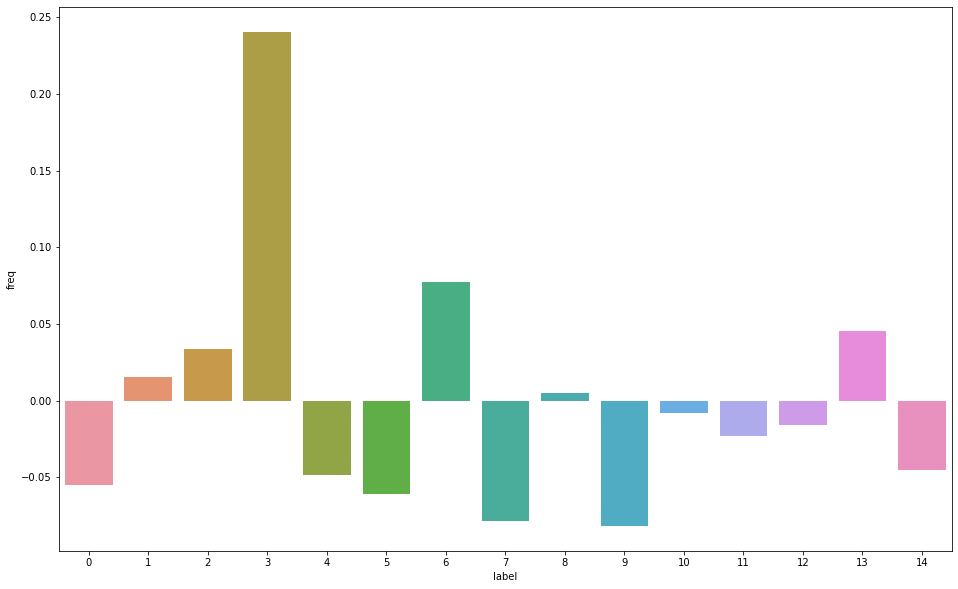

In [105]:
# making a visual plot for customer frequency & population frequency:
fig, ax = plt.subplots(figsize=(16,10))
ax=sns.barplot(x=customer_per_dataset.label, y=customer_per_dataset.freq - pop_per_dataset .freq)

In [106]:

df_customer_pca = df_customer_pca.rename(columns = {1: 'pop_density-finance_status',
                                            2: 'age-generation',
                                            3: 'gender'}
                                )

In [107]:
df_customer_pca

,pop_density-finance_status,age-generation,gender,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,labels
0,-5.617583,0.724186,4.133790,-1.652195,-0.016476,2.703735,0.362664,1.115850,1.484255,1.163655,...,-0.511544,-0.270020,0.292290,0.376325,-0.281625,0.811477,0.532237,-0.232466,-1.175095,3
1,-1.654051,4.836886,-0.601717,-2.243331,1.532050,-0.773197,-0.374817,-0.012631,0.007124,1.813769,...,-0.403361,0.728391,0.062325,0.025312,-0.170983,-0.778196,-0.234895,-1.108310,0.181701,13
2,-4.377336,0.264871,2.713709,1.186662,-2.254004,0.612329,1.000226,1.366128,-0.745965,0.857711,...,1.154509,-0.731104,-0.755108,-0.346377,-0.333486,-0.968673,-0.288403,0.427317,0.491486,6
3,1.405207,-0.725530,1.351654,-0.206660,-0.519603,0.324450,-1.294990,-0.557940,-0.386155,2.000876,...,-1.369958,1.253198,0.028962,0.033099,0.634679,-0.323533,0.003510,0.415043,-0.216554,14
4,-2.256527,1.226174,2.848183,-2.762972,0.709404,2.039575,-0.862875,-1.091420,0.114005,-1.225353,...,0.135655,-0.097458,-0.925259,-0.713354,-0.772458,-0.425789,-0.656296,-1.079070,0.362953,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141227,-1.338733,1.249123,3.131459,-4.032621,2.308781,0.668366,-0.978209,0.924666,-1.807520,-1.119188,...,-1.382118,-0.064514,-1.075456,-0.254785,-0.456037,-0.394298,0.565783,-0.556842,-0.639495,3
141228,-3.738138,2.563889,-1.637750,1.962197,0.418347,2.304156,0.005088,-0.362137,-0.103446,0.649454,...,0.702722,-0.899436,-2.365912,-0.058157,0.851426,-0.037851,-0.169496,-0.361970,0.635548,12
141229,-4.317346,2.787915,2.606825,-2.331575,0.532611,0.485625,-0.257187,-0.578345,1.544786,-1.080719,...,1.115319,-0.691746,0.779487,-0.667875,0.374807,-0.384215,0.005156,-0.953954,1.533267,3
141230,-0.993128,2.891810,-1.839403,-0.444194,-0.661127,-1.691922,0.285599,1.265137,-0.523647,0.710699,...,0.083559,0.627555,0.974588,-1.371157,-1.064276,-0.758368,0.736532,0.163787,0.667352,12


In [108]:
def map_cluster_to_feats(kmeans, df, cnum):
    
    # Returns two pd by mapping pca weights to individual features.
    # One series has the highest positive weights, while the other has the lowest negative weights.
  
    
    # Getting coordinates of cluster centeroids:
    weights = pd.DataFrame(np.round(kmeans.cluster_centers_, 4), columns=df.keys())
    centroid = weights.iloc[cnum, :]
    
    # Capturing the postive pca features:
    centroid_pos = centroid[centroid > 0].sort_values(ascending=False).to_frame()
    centroid_pos.reset_index(level=0, inplace=True)
    centroid_pos.columns = ['top_positive_col','top_positive_col_weight']
    
    # Capturing the negative pca features:
    centroid_neg = centroid[centroid < 0].sort_values(ascending=True).to_frame()
    centroid_neg.reset_index(level=0, inplace=True)
    centroid_neg.columns = ['top_negative_col','top_negative_col_weight']
    
    # Combining postive and negative pca features:
    top_pca_feat = pd.concat([centroid_pos, centroid_neg], axis=1)
    top_pca_feat['top_negative_col'] = top_pca_feat['top_negative_col'].apply(str)
    top_pca_feat['top_positive_col'] = top_pca_feat['top_positive_col'].apply(str)
    return top_pca_feat

In [109]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Based on the barplot.the overrepresented segment is cluster "3". 
top_pca_feat = map_cluster_to_feats(kmeans_model, df_customer_pca.iloc[:, :-1], 3)
top_pca_feat.style.bar(align='mid')



,top_positive_col,top_positive_col_weight,top_negative_col,top_negative_col_weight
0,gender,2.680100,pop_density-finance_status,-3.354600
1,5,0.945800,4,-2.123500
2,9,0.275300,15,-0.668400
3,26,0.241000,6,-0.206400
4,20,0.220400,22,-0.125300
5,7,0.155300,11,-0.121300
6,21,0.111600,14,-0.100400
7,23,0.087700,age-generation,-0.087200
8,25,0.076400,10,-0.080400
9,16,0.047600,17,-0.068900


In [113]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# Based on the barplot, the selected underrepresented segment could be cluster "9" or "7". 

#cluster "9"
top_pca_feat = map_cluster_to_feats(kmeans_model, df_customer_pca.iloc[:, :-1], 9)
top_pca_feat.style.bar(align='mid')


,top_positive_col,top_positive_col_weight,top_negative_col,top_negative_col_weight
0,pop_density-finance_status,4.550100,gender,-2.633800
1,8,0.750400,age-generation,-1.366600
2,12,0.204500,4,-0.399500
3,22,0.107300,24,-0.202700
4,18,0.077200,17,-0.197900
5,26,0.075700,7,-0.166700
6,25,0.070100,6,-0.146200
7,21,0.052900,11,-0.132200
8,23,0.045900,10,-0.131300
9,5,0.032100,19,-0.126300


In [114]:
#cluster "7"
top_pca_feat = map_cluster_to_feats(kmeans_model, df_customer_pca.iloc[:, :-1], 7)
top_pca_feat.style.bar(align='mid')

,top_positive_col,top_positive_col_weight,top_negative_col,top_negative_col_weight
0,pop_density-finance_status,4.550100,gender,-2.633800
1,8,0.750400,age-generation,-1.366600
2,12,0.204500,4,-0.399500
3,22,0.107300,24,-0.202700
4,18,0.077200,17,-0.197900
5,26,0.075700,7,-0.166700
6,25,0.070100,6,-0.146200
7,21,0.052900,11,-0.132200
8,23,0.045900,10,-0.131300
9,5,0.032100,19,-0.126300


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

- The Overrepresented customer segment is **cluster#3**, which has significant positive influence on the gender component and significant negtive influence on population density and financial condition component. In addition, it have a relatively small negative influence on the age component.

- So the mail-order company's customers are more likely: younger males who are less dreamy, less socially and culturally conscious, not financially limited, and live in less densely populated places.


- The selected underrepresented customer segment is **cluster#7**, which has a sigificant positive influence on population density and financial condition component and a sigificant negative influence on gender & age-generation component.

- On ther other hand, younger women who are less dominant-minded, less critical-minded, less rational, have a less confrontational attitude, are less prone to investing, and reside in densely crowded areas with lower financial standing are among the population who are relatively unpopular with the mail-order corporation. 

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.